# Team Project. **Colored MNIST Dataset을 활용한 분류기 생성**
### 과목 코드 : **2150034001 (수 09:00)**
### 팀명 : **JWCA**
### 팀장 : **정재훈 (20202996)**
### 팀원 : **안지수 (20221602)**
### 팀원 : **위찬우 (20202982)**
### 팀원 : **최연서 (20221628)**

## **<font color = 'red'>1.</font> 데이터 준비, 분석 및 전처리**

**필요한 라이브러리를 Import하고, 최초의 MNIST Dataset을 Load한 뒤 Colored MNIST를 생성하기 위한 함수들을 정의합니다.**

In [ ]:
# ========== 필요한 라이브러리 Import ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
from torchvision import datasets, transforms


# ========== MNIST 데이터셋 로드 ==========

# Load한 Dataset을 Tensor 형태로 변환
transform = transforms.Compose([transforms.ToTensor()])

# Train Set을 Load
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Test Set을 Load
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# ========== 무지개 색상 팔레트 정의 (7가지 색상) ==========

RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
    ]
RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
    ]


# ========== Colored MNIST Dataset을 만들기 위한 함수들 정의 ==========

# 결과의 재현성을 보장하기 위해 Random 시드 설정
np.random.seed(42)

# 무지개 팔레트에서 임의의 색을 선택하는 함수 정의
def get_random_rainbow_color() :
  idx = np.random.randint(0, len(RAINBOW_COLORS))
  return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

# 숫자 이미지에 Foreground, Background 색상을 적용하는 함수 정의
def colorize_digit(digit_image, fg_color, bg_color) :
  digit = digit_image.convert('L')  # Grayscale로 변환
  colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
  return colored_digit

# 이미지의 투명도 제거 및 일관된 배경 이미지 생성
def overlay_digit_on_background(colored_digit) :
  final_image = colored_digit.convert('RGB')
  return final_image

# 각 숫자 이미지 정보를 DataFrame에 추가하는 함수 정의
def image_to_dataframe(image, label) :
  # 이미지 배열을 (28, 28, 3)에서 (2352,)로 변환
  image_array = np.array(image).reshape(-1)
  return np.concatenate([[label], image_array])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 615kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.57MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.64MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Dataset에 포함되어 있는 Sample 한 개를 이용하여 Colored MNIST 데이터셋의 Sample이 어떻게 구성될 것인지 확인합니다.**

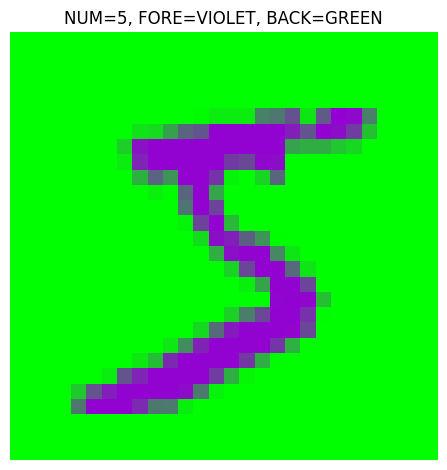

In [ ]:
# 최초 Dataset 확인을 위해 임의의 Sample을 시각화
image, label = mnist_train[0]
pil_image = transforms.ToPILImage()(image)

fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

colored_digit = colorize_digit(pil_image, fg_color, bg_color)
if image is not None :
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')
  plt.tight_layout()
  plt.show()

In [ ]:
# 최초의 Dataset 구조 확인
print(f"최초의 Dataset Type : {type(mnist_train)}")
transform = transforms.ToTensor()
tensor_image = transform(final_image)

print("")
print(f"Tensor 데이터로 변환 후 Shape : {tensor_image.shape}")
print("")
print(f"Tensor Dataset에서의 수치 데이터 확인 :")
print(f"최솟값 : {tensor_image.min()}, 최댓값 : {tensor_image.max()}, 평균 : {tensor_image.mean()}, 중앙값 : {tensor_image.median()}, 분산 : {tensor_image.var()}")

최초의 Dataset Type : <class 'torchvision.datasets.mnist.MNIST'>

Tensor 데이터로 변환 후 Shape : torch.Size([3, 28, 28])

Tensor Dataset에서의 수치 데이터 확인 :
최솟값 : 0.0, 최댓값 : 1.0, 평균 : 0.351767361164093, 중앙값 : 0.0, 분산 : 0.19615045189857483


**Tensor 형태로 변환한 Dataset은 이미지의 Pixel 값을 R, G, B의 값으로 분리하여 담고 있는 것을 확인합니다.**

**<font color = 'red'>R</font>**

In [ ]:
numpy_array_R = tensor_image[0].numpy()
df_R = pd.DataFrame(numpy_array_R)
df_R

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.058824,0.376471,0.580392,0.560784,0.286275,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.078431,...,0.509804,0.388235,0.572549,0.549020,0.443137,0.145098,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.109804,0.541176,0.572549,...,0.207843,0.184314,0.184314,0.125490,0.086275,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.039216,0.498039,0.572549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.180392,0.352941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


**<font color = 'green'>G</font>**

In [ ]:
numpy_array_G = tensor_image[1].numpy()
df_G = pd.DataFrame(numpy_array_G)
df_G

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.313726,0.898039,0.349020,0.000000,0.031373,0.501961,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.882353,0.858824,...,0.117647,0.325490,0.007843,0.050980,0.235294,0.749020,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.807843,0.066667,0.007843,...,0.635294,0.678431,0.678431,0.780392,0.847059,1.000000,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.929412,0.141176,0.007843,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.686275,0.388235,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0


**<font color = 'blue'>B</font>**

In [ ]:
numpy_array_B = tensor_image[2].numpy()
df_B = pd.DataFrame(numpy_array_B)
df_B

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.564706,0.082353,0.537255,0.827451,0.800000,0.411765,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.094118,0.113725,...,0.729412,0.556863,0.819608,0.784314,0.631373,0.203922,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.156863,0.768627,0.819608,...,0.298039,0.262745,0.262745,0.180392,0.125490,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.054902,0.709804,0.819608,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.258824,0.505882,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


**모델 학습에 용이하게 사용하고자 DataFrame 형태로 변환하고자 합니다. 함수를 정의하고 Dataset을 DataFrame 형태로 변환합니다.**

In [ ]:
# Colored MNIST DataFrame을 생성하고 저장하는 함수
def create_colored_mnist_dataframe(mnist_dataset) :
  data_list = []     # DataFrame을 만들기 위해 각 Sample을 담을 List 초기화
  fg_list = []
  bg_list = []
  np.random.seed(42) # 결과의 재현성을 위해 랜덤 시드 설정

  for idx in range(len(mnist_dataset)) :
    # 차례대로 (인덱스 단위로) 데이터 불러오기
    image, label = mnist_dataset[idx]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()
    while bg_color == fg_color : # 전경과 배경이 같은 색상일 경우 다른 색상으로 설정될 때까지 조정
      bg_color, bg_label = get_random_rainbow_color()

    # 숫자 이미지에 색상 적용 후 투명도 제거
    colored_image = colorize_digit(pil_image, fg_color, bg_color)
    final_image = overlay_digit_on_background(colored_image)

    # DataFrame을 만들기 위한 List에 추가
    data_row = image_to_dataframe(final_image, label)
    data_list.append(data_row)
    fg_list.append(fg_label)
    bg_list.append(bg_label)

  # DataFrame 생성
  columns = ['Label'] + [f'Pixel_{i//3}_{"R" if (i%3 == 0) else ("G" if (i%3 == 1) else "B")}' for i in range(28 * 28 * 3)]
  df_data = pd.DataFrame(data_list, columns=columns)
  df_fg = pd.DataFrame(fg_list, columns=["Foreground"])
  df_bg = pd.DataFrame(bg_list, columns=["Background"])
  return df_data, df_fg, df_bg

**최초의 Dataset을 Load할 때, Train Set과 Test Set을 분리하여 Load하였기 때문에 별도의 분리 과정 없이 각자 DataFrame으로 변환합니다.**

In [ ]:
# Train Set에 대한 DataFrame 생성
# Colab의 시스템 RAM 사용량 최적화를 위해 Pixel + Label / Foreground / Background 에 대한 DataFrame을 각자 생성
colored_mnist_train, fg_train, bg_train = create_colored_mnist_dataframe(mnist_train)

In [ ]:
# Test Set에 대한 DataFrame 생성
# Colab의 시스템 RAM 사용량 최적화를 위해 Pixel + Label / Foreground / Background 에 대한 DataFrame을 각자 생성
colored_mnist_test, fg_test, bg_test = create_colored_mnist_dataframe(mnist_test)

In [ ]:
# Train Set에 대한 DataFrame 생성 (Pixel + 모든 Label을 하나의 Sample (Row)로 구성)
# Colab의 시스템 RAM 용량 문제로 데이터를 나눠서도 진행해봤지만 무료 Version에서는 구동이 어려웠음.

# from torch.utils.data import Subset, DataLoader
# mnist_train_01 = Subset(mnist_train, range(0, 30000))  # 데이터셋을 분리하여 선택
# colored_mnist_train_01, fg_train_01, bg_train_01 = create_colored_mnist_dataframe(mnist_train_01)

**Train Set과 Test Set이 성공적으로 변환되었는지 확인합니다.**

In [ ]:
colored_mnist_train

,Label,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,5,0,255,0,0,255,0,0,255,0,...,0,0,255,0,0,255,0,0,255,0
1,0,148,0,211,148,0,211,148,0,211,...,211,148,0,211,148,0,211,148,0,211
2,4,0,0,255,0,0,255,0,0,255,...,255,0,0,255,0,0,255,0,0,255
3,1,148,0,211,148,0,211,148,0,211,...,211,148,0,211,148,0,211,148,0,211
4,9,255,255,0,255,255,0,255,255,0,...,0,255,255,0,255,255,0,255,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,255,0,0,255,0,0,255,0,...,0,0,255,0,0,255,0,0,255,0
59996,3,75,0,130,75,0,130,75,0,130,...,130,75,0,130,75,0,130,75,0,130
59997,5,75,0,130,75,0,130,75,0,130,...,130,75,0,130,75,0,130,75,0,130
59998,6,255,127,0,255,127,0,255,127,0,...,0,255,127,0,255,127,0,255,127,0


In [ ]:
colored_mnist_test

,Label,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,7,0,255,0,0,255,0,0,255,0,...,0,0,255,0,0,255,0,0,255,0
1,2,148,0,211,148,0,211,148,0,211,...,211,148,0,211,148,0,211,148,0,211
2,1,0,0,255,0,0,255,0,0,255,...,255,0,0,255,0,0,255,0,0,255
3,0,148,0,211,148,0,211,148,0,211,...,211,148,0,211,148,0,211,148,0,211
4,4,255,255,0,255,255,0,255,255,0,...,0,255,255,0,255,255,0,255,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,255,127,0,255,127,0,255,127,0,...,0,255,127,0,255,127,0,255,127,0
9996,3,255,255,0,255,255,0,255,255,0,...,0,255,255,0,255,255,0,255,255,0
9997,4,0,255,0,0,255,0,0,255,0,...,0,0,255,0,0,255,0,0,255,0
9998,5,148,0,211,148,0,211,148,0,211,...,211,148,0,211,148,0,211,148,0,211


In [ ]:
# 각 Dataset의 크기 확인
print(f"Train Set DataFrame Shape : {colored_mnist_train.shape}")
print(f"Test Set DataFrame Shape  : {colored_mnist_test.shape}")

Train Set DataFrame Shape : (60000, 2353)
Test Set DataFrame Shape  : (10000, 2353)


**Dataset에서 모델 학습에 사용할 데이터와 Label로 활용할 데이터를 분리합니다.**

In [ ]:
x_train = colored_mnist_train.drop(columns=['Label'])
y_train_lb = colored_mnist_train['Label']

x_test = colored_mnist_test.drop(columns=['Label'])
y_test_lb = colored_mnist_test['Label']

**Train Set을 확인합니다. Label 데이터의 경우 각 Class가 어떻게 구성되어 있는지 확인합니다.**

In [ ]:
x_train

,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,Pixel_3_R,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,0,255,0,0,255,0,0,255,0,0,...,0,0,255,0,0,255,0,0,255,0
1,148,0,211,148,0,211,148,0,211,148,...,211,148,0,211,148,0,211,148,0,211
2,0,0,255,0,0,255,0,0,255,0,...,255,0,0,255,0,0,255,0,0,255
3,148,0,211,148,0,211,148,0,211,148,...,211,148,0,211,148,0,211,148,0,211
4,255,255,0,255,255,0,255,255,0,255,...,0,255,255,0,255,255,0,255,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,255,0,0,255,0,0,255,0,0,...,0,0,255,0,0,255,0,0,255,0
59996,75,0,130,75,0,130,75,0,130,75,...,130,75,0,130,75,0,130,75,0,130
59997,75,0,130,75,0,130,75,0,130,75,...,130,75,0,130,75,0,130,75,0,130
59998,255,127,0,255,127,0,255,127,0,255,...,0,255,127,0,255,127,0,255,127,0


In [ ]:
y_train_lb

,Label
0,5
1,0
2,4
3,1
4,9
...,...
59995,8
59996,3
59997,5
59998,6


In [ ]:
y_train_lb.value_counts()

,count
Label,
1,6742
7,6265
3,6131
2,5958
9,5949
0,5923
6,5918
8,5851
4,5842


In [ ]:
y_train_fg = fg_train
y_train_fg

,Foreground
0,VIOLET
1,BLUE
2,YELLOW
3,BLUE
4,ORANGE
...,...
59995,BLUE
59996,RED
59997,GREEN
59998,RED


In [ ]:
y_train_fg.value_counts()

,count
Foreground,
BLUE,8766
ORANGE,8599
VIOLET,8592
RED,8587
INDIGO,8540
GREEN,8535
YELLOW,8381


In [ ]:
y_train_bg = bg_train
y_train_bg

,Background
0,GREEN
1,VIOLET
2,BLUE
3,VIOLET
4,YELLOW
...,...
59995,GREEN
59996,INDIGO
59997,INDIGO
59998,ORANGE


In [ ]:
y_train_bg.value_counts()

,count
Background,
GREEN,8635
ORANGE,8600
YELLOW,8576
VIOLET,8569
RED,8543
INDIGO,8542
BLUE,8535


**Test Set이 학습에 관여되지 않기 위해 최종 성능 평가를 제외한 최적화 과정에서의 성능 평가를 위한 Validation Set을 Train Set의 일부로 구성합니다.**

In [ ]:
# Train Set의 20%를 Validation Set으로 구성
x_valid = x_train[48000:60000]
x_train = x_train[0:48000]

y_valid_lb = y_train_lb[48000:60000]
y_train_lb = y_train_lb[0:48000]

y_valid_fg = y_train_fg[48000:60000]
y_train_fg = y_train_fg[0:48000]

y_valid_bg = y_train_bg[48000:60000]
y_train_bg = y_train_bg[0:48000]

In [ ]:
x_train

,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,Pixel_3_R,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,0,255,0,0,255,0,0,255,0,0,...,0,0,255,0,0,255,0,0,255,0
1,148,0,211,148,0,211,148,0,211,148,...,211,148,0,211,148,0,211,148,0,211
2,0,0,255,0,0,255,0,0,255,0,...,255,0,0,255,0,0,255,0,0,255
3,148,0,211,148,0,211,148,0,211,148,...,211,148,0,211,148,0,211,148,0,211
4,255,255,0,255,255,0,255,255,0,255,...,0,255,255,0,255,255,0,255,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,255,255,0,255,255,0,255,255,0,255,...,0,255,255,0,255,255,0,255,255,0
47996,148,0,211,148,0,211,148,0,211,148,...,211,148,0,211,148,0,211,148,0,211
47997,148,0,211,148,0,211,148,0,211,148,...,211,148,0,211,148,0,211,148,0,211
47998,0,255,0,0,255,0,0,255,0,0,...,0,0,255,0,0,255,0,0,255,0


In [ ]:
x_valid

,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,Pixel_3_R,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
48000,0,0,255,0,0,255,0,0,255,0,...,255,0,0,255,0,0,255,0,0,255
48001,75,0,130,75,0,130,75,0,130,75,...,130,75,0,130,75,0,130,75,0,130
48002,255,0,0,255,0,0,255,0,0,255,...,0,255,0,0,255,0,0,255,0,0
48003,75,0,130,75,0,130,75,0,130,75,...,130,75,0,130,75,0,130,75,0,130
48004,255,0,0,255,0,0,255,0,0,255,...,0,255,0,0,255,0,0,255,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,255,0,0,255,0,0,255,0,0,...,0,0,255,0,0,255,0,0,255,0
59996,75,0,130,75,0,130,75,0,130,75,...,130,75,0,130,75,0,130,75,0,130
59997,75,0,130,75,0,130,75,0,130,75,...,130,75,0,130,75,0,130,75,0,130
59998,255,127,0,255,127,0,255,127,0,255,...,0,255,127,0,255,127,0,255,127,0


**원활한 학습을 진행하기 위해 Feature Scaling을 진행하고자 합니다. Normalization 방법 중 하나인 Min-Max Scaling을 적용하고자 합니다. 해당 기법을 적용한 이유는 다음과 같습니다.**

1. **특성의 범위 축소를 통한 학습 불안정성과 특정 특성의 지배성 감소**

2. **최적화 알고리즘 및 손실 함수 사용 시 최적화의 균형 유지**

**이를 통해 학습의 속도 및 성능을 향상시킬 수 있습니다.**

In [ ]:
# Pixel 값이 0부터 255까지인지 확인
print("Train Set's Max Pixel Value      :", x_train.max().max())
print("Train Set's Min Pixel Value      :", x_train.min().min())
print("Validation Set's Max Pixel Value :", x_valid.max().max())
print("Validation Set's Min Pixel Value :", x_valid.min().min())
print("Test Set's Max Pixel Value       :", x_test.max().max())
print("Test Set's Min Pixel Value       :", x_test.min().min())

Train Set's Max Pixel Value      : 255
Train Set's Min Pixel Value      : 0
Validation Set's Max Pixel Value : 255
Validation Set's Min Pixel Value : 0
Test Set's Max Pixel Value       : 255
Test Set's Min Pixel Value       : 0


**현재 다루는 Colored MNIST Dataset은 최솟값, 최댓값을 이용하여 직접 계산할 수 있는 정도이므로 직접 연산하는 방식으로 Min-Max Scaling을 진행합니다.**

$$x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$$


In [ ]:
x_train_mms = x_train / 255
x_valid_mms = x_valid / 255
x_test_mms = x_test / 255

In [ ]:
x_train_mms

,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,Pixel_3_R,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000
1,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
2,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,...,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000
3,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
4,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,...,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,...,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000
47996,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
47997,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
47998,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000


**Feature Scaling을 통해 성능 향상을 얻을 수 있는지 확인합니다.**

**1. <font color = 'orange'>K-Nearest Neighbors</font> 모델을 통해 확인**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

import time

In [ ]:
# Min-Max Scaling 전 성능 확인 (숫자 분류 성능)

feature_scaling_check_model = KNeighborsClassifier()
feature_scaling_check_modelName = 'Before Min-Max Scaling'

learning_start = time.time()
feature_scaling_check_model.fit(x_train, y_train_lb)
time.sleep(1)
y_pred_lb = feature_scaling_check_model.predict(x_valid)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {feature_scaling_check_modelName}")
print(f"Accuracy : {accuracy}")
print("Classification Report :")
print(report)
print(f"{time.time()-learning_start:.4f} sec.")

Model : Before Min-Max Scaling
Accuracy : 0.9046666666666666
Classification Report :
              precision    recall  f1-score   support

           0     0.9235    0.9807    0.9513      1194
           1     0.8230    0.9945    0.9007      1272
           2     0.9726    0.8620    0.9140      1196
           3     0.8923    0.9203    0.9061      1242
           4     0.9277    0.8644    0.8949      1187
           5     0.9136    0.8487    0.8800      1097
           6     0.9405    0.9726    0.9563      1170
           7     0.9128    0.9121    0.9125      1297
           8     0.9581    0.8022    0.8732      1198
           9     0.8254    0.8779    0.8509      1147

    accuracy                         0.9047     12000
   macro avg     0.9090    0.9035    0.9040     12000
weighted avg     0.9086    0.9047    0.9043     12000

127.2927 sec.


In [ ]:
# Min-Max Scaling 후 성능 확인 (숫자 분류 성능)

feature_scaling_check_model2 = KNeighborsClassifier()
feature_scaling_check_modelName2 = 'After Min-Max Scaling'

learning_start2 = time.time()
feature_scaling_check_model2.fit(x_train_mms, y_train_lb)
time.sleep(1)
y_pred_lb = feature_scaling_check_model2.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {feature_scaling_check_modelName2}")
print(f"Accuracy : {accuracy}")
print("Classification Report :")
print(report)
print(f"{time.time()-learning_start2:.4f} sec.")

Model : After Min-Max Scaling
Accuracy : 0.9046666666666666
Classification Report :
              precision    recall  f1-score   support

           0     0.9235    0.9807    0.9513      1194
           1     0.8230    0.9945    0.9007      1272
           2     0.9726    0.8620    0.9140      1196
           3     0.8923    0.9203    0.9061      1242
           4     0.9277    0.8644    0.8949      1187
           5     0.9136    0.8487    0.8800      1097
           6     0.9405    0.9726    0.9563      1170
           7     0.9128    0.9121    0.9125      1297
           8     0.9581    0.8022    0.8732      1198
           9     0.8254    0.8779    0.8509      1147

    accuracy                         0.9047     12000
   macro avg     0.9090    0.9035    0.9040     12000
weighted avg     0.9086    0.9047    0.9043     12000

113.8248 sec.


**학습 속도에서의 성능 향상을 확인하였습니다.**<br>
**(첫 실행때는 가끔 Scaling 이후가 더 오래 걸리기도 했지만, 그 이후 실행에서는 Scaling 이후의 속도가 더 빠름을 확인하였습니다.)**

**2. <font color = 'orange'>Decision Tree</font> 모델을 통해 확인**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

import time

In [ ]:
# Min-Max Scaling 전 성능 확인 (숫자 분류 성능)

feature_scaling_check_model3 = DecisionTreeClassifier()
feature_scaling_check_modelName3 = 'Before Min-Max Scaling'

learning_start3 = time.time()
feature_scaling_check_model3.fit(x_train, y_train_lb)
time.sleep(1)
y_pred_lb = feature_scaling_check_model3.predict(x_valid)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {feature_scaling_check_modelName3}")
print(f"Accuracy : {accuracy}")
print("Classification Report :")
print(report)
print(f"{time.time()-learning_start3:.4f} sec.")

Model : Before Min-Max Scaling
Accuracy : 0.7320833333333333
Classification Report :
              precision    recall  f1-score   support

           0     0.8450    0.8400    0.8425      1194
           1     0.8497    0.8978    0.8731      1272
           2     0.7039    0.6697    0.6864      1196
           3     0.6654    0.6836    0.6743      1242
           4     0.7017    0.7195    0.7105      1187
           5     0.6271    0.6162    0.6216      1097
           6     0.7555    0.7684    0.7619      1170
           7     0.8031    0.8080    0.8055      1297
           8     0.6723    0.5993    0.6337      1198
           9     0.6642    0.6931    0.6783      1147

    accuracy                         0.7321     12000
   macro avg     0.7288    0.7296    0.7288     12000
weighted avg     0.7310    0.7321    0.7311     12000

86.5735 sec.


In [ ]:
# Min-Max Scaling 후 성능 확인 (숫자 분류 성능)

feature_scaling_check_model4 = DecisionTreeClassifier()
feature_scaling_check_modelName4 = 'After Min-Max Scaling'

learning_start4 = time.time()
feature_scaling_check_model4.fit(x_train_mms, y_train_lb)
time.sleep(1)
y_pred_lb = feature_scaling_check_model4.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {feature_scaling_check_modelName4}")
print(f"Accuracy : {accuracy}")
print("Classification Report :")
print(report)
print(f"{time.time()-learning_start4:.4f} sec.")

Model : After Min-Max Scaling
Accuracy : 0.7333333333333333
Classification Report :
              precision    recall  f1-score   support

           0     0.8519    0.8384    0.8451      1194
           1     0.8527    0.9009    0.8761      1272
           2     0.6877    0.6756    0.6816      1196
           3     0.6771    0.6787    0.6779      1242
           4     0.7025    0.7439    0.7226      1187
           5     0.6189    0.6217    0.6203      1097
           6     0.7820    0.7667    0.7743      1170
           7     0.7980    0.8042    0.8011      1297
           8     0.6601    0.5918    0.6241      1198
           9     0.6712    0.6870    0.6790      1147

    accuracy                         0.7333     12000
   macro avg     0.7302    0.7309    0.7302     12000
weighted avg     0.7324    0.7333    0.7325     12000

63.4723 sec.


> **최종 Colored MNIST Dataset**

- **<font color = 'orange'>Train</font> Set**<br>
  **x_train / y_train_lb, y_train_fg, y_train_bg**

- **<font color = 'blue'>Validation</font> Set**<br>
  **x_valid / y_valid_lb, y_valid_fg, y_valid_bg**

- **<font color = 'purple'>Test</font> Set**<br>
  **x_test / y_test_lb, y_test_fg, y_test_bg**

## **<font color = 'green'>2.</font> 데이터 증강**

**데이터 증강을 통해 새로운 데이터를 만들고, 이를 학습에 사용하여 다음과 같은 결과를 얻고자 합니다.**

1. **학습 데이터의 다양성을 통해 학습 능력 강화**
2. **강화된 학습을 통해 부족한 성능 보완 / 전체 성능 향상**



**직접 수집한 Custom Font를 이용하여 새로운 숫자 이미지를 생성합니다.**

### **<font color = 'green'>2-1.</font> 최초 데이터 증강**

폰트 'Cabin_Condensed-SemiBold'에서 숫자 생성 완료
폰트 'WorkSans-ExtraLight'에서 숫자 생성 완료
폰트 'IBMPlexSans-Regular'에서 숫자 생성 완료
폰트 'NotoSansKR-SemiBold'에서 숫자 생성 완료
폰트 'BarlowCondensed-Italic'에서 숫자 생성 완료
폰트 'IBMPlexSans-Light'에서 숫자 생성 완료
폰트 'MateSC-Regular'에서 숫자 생성 완료
폰트 'SourGummy_Expanded-Thin'에서 숫자 생성 완료
폰트 'Exo2-VariableFont_wght'에서 숫자 생성 완료
폰트 'Epilogue-ExtraLight'에서 숫자 생성 완료
폰트 'WorkSans-BlackItalic'에서 숫자 생성 완료
폰트 'Cabin_Condensed-MediumItalic'에서 숫자 생성 완료
폰트 'JosefinSlab-Italic'에서 숫자 생성 완료
폰트 'SourGummy_Expanded-MediumItalic'에서 숫자 생성 완료
폰트 'SourGummy_SemiExpanded-Light'에서 숫자 생성 완료
폰트 'Exo2-Medium'에서 숫자 생성 완료
폰트 'CrimsonPro-Medium'에서 숫자 생성 완료
폰트 'SourGummy_Expanded-SemiBoldItalic'에서 숫자 생성 완료
폰트 'SourGummy-SemiBold'에서 숫자 생성 완료
폰트 'CrimsonPro-ExtraLightItalic'에서 숫자 생성 완료
폰트 'SourGummy_SemiExpanded-ExtraBold'에서 숫자 생성 완료
폰트 'BarlowCondensed-Medium'에서 숫자 생성 완료
폰트 'BarlowCondensed-BoldItalic'에서 숫자 생성 완료
폰트 'NotoSansKR-ExtraLight'에서 숫자 생성 완료
폰트 'Cabin-BoldItalic'에서 숫자 생성 완료
폰트 'IBMPlexSans-MediumItalic'

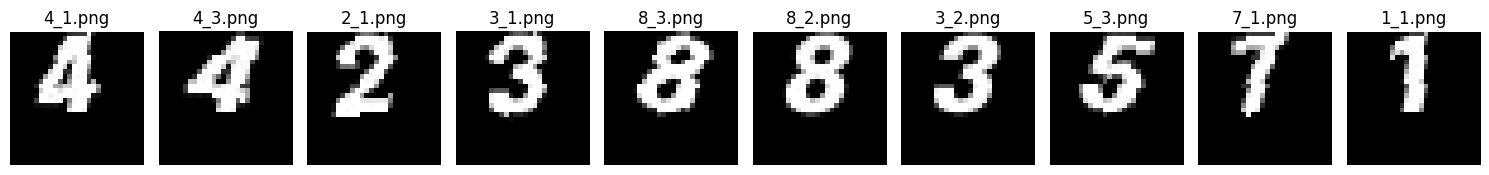

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

from glob import glob
from PIL import Image, ImageDraw, ImageFont

# MNIST와 동일한 이미지 크기와 폰트 크기 설정
IMAGE_SIZE = (28, 28) # 이미지 크기 (28 x 28)
FONT_SIZE = 22        # 폰트 크기

# 폰트 경로 설정
FONT_PATHS = '/content/custom_font'
FONT_FILE_NAMES = glob(f"{FONT_PATHS}/*.ttf")
FONT_PATHS = list(map(str, FONT_FILE_NAMES))

# 출력 디렉토리 설정
OUTPUT_DIR = '/content/custom_font_png'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 숫자 데이터를 생성 (증강)하는 함수
def generate_digit_image(digit, font_path, angle, noise_std):

    # 하얀색 배경 이미지 생성
    image = Image.new("L", IMAGE_SIZE, 255) # 하얀색 배경 이미지 (Grayscale)
    draw = ImageDraw.Draw(image)

    # 폰트 불러오기
    font = ImageFont.truetype(font_path, FONT_SIZE)

    # 텍스트 경계 상자 (Bounding box) 계산
    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # 중앙 배치
    dx = 0
    dy = -6
    position = ((IMAGE_SIZE[0] - text_width) // 2 + dx,
                (IMAGE_SIZE[1] - text_height) // 2 + dy)
    draw.text(position, str(digit), fill=0, font=font)

    # 각도 변형
    rotated_image = image.rotate(angle, fillcolor=255)

    # 숫자에만 노이즈 추가
    digit_array = np.array(rotated_image)
    digit_mask = (digit_array < 255).astype(np.uint8)           # 숫자 영역 마스크 생성
    noise = np.random.normal(0, noise_std, IMAGE_SIZE)          # 노이즈 생성
    noisy_digit = digit_array + digit_mask * noise              # 숫자 영역에만 노이즈 추가
    noisy_digit = np.clip(noisy_digit, 0, 255).astype(np.uint8) # 값 범위 제한

    return Image.fromarray(noisy_digit)

# 폰트 별로 데이터를 생성하고 저장하는 함수
def generate_and_save_data():
    for font_path in FONT_PATHS:
        font_name = os.path.basename(font_path).split('.')[0] # 폰트 이름 추출
        font_dir = os.path.join(OUTPUT_DIR, font_name)
        os.makedirs(font_dir, exist_ok=True)

        for digit in range(10):      # 0부터 9까지의 숫자
            angles = [10, 0, -10]    # 숫자를 회전시킬 각도 (10도, 0도, -10도)
            generated_images = set() # 중복 방지용 집합

            for count, angle in enumerate(angles):
                noise_std = random.uniform(0, 5)  # 0 ~ 5 사이의 랜덤 노이즈
                img = generate_digit_image(digit, font_path, angle, noise_std)

                # 중복 방지를 위해 이미지를 해시 값으로 변환
                img_hash = hash(img.tobytes())
                if img_hash not in generated_images:
                    generated_images.add(img_hash)
                    img_path = os.path.join(
                        font_dir, f"{digit}_{count + 1}.png")
                    img.save(img_path)

        print(f"폰트 '{font_name}'에서 숫자 생성 완료")

# 저장된 데이터를 시각화 하는 함수
def visualize_saved_data(output_dir, num_samples=10):
    font_dirs = [os.path.join(output_dir, d) for d in os.listdir(
        output_dir) if os.path.isdir(os.path.join(output_dir, d))]
    if not font_dirs:
        print("저장된 폴더가 없습니다.")
        return

    # 무작위 폰트 디렉토리와 숫자 파일 선택
    random_font_dir = random.choice(font_dirs)
    print(f"랜덤 폴더 선택 : {random_font_dir}")

    image_files = [os.path.join(random_font_dir, f) for f in os.listdir(
        random_font_dir) if f.endswith('.png')]
    if not image_files:
        print(f"{random_font_dir}에 저장된 이미지가 없습니다.")
        return

    selected_files = random.sample(
        image_files, min(num_samples, len(image_files)))

    # 이미지 시각화
    fig, axes = plt.subplots(1, len(selected_files), figsize=(15, 3))
    for ax, img_path in zip(axes, selected_files):
        img = Image.open(img_path)
        ax.imshow(255 - np.array(img), cmap='gray')  # 하얀색을 배경으로 반전
        ax.axis('off')
        ax.set_title(os.path.basename(img_path))
    plt.tight_layout()
    plt.show()

# 데이터 생성
generate_and_save_data()

# 생성된 데이터 확인
visualize_saved_data(OUTPUT_DIR)

**생성한 .PNG 이미지 데이터들을 .NPZ 데이터로 변환합니다.**

In [ ]:
# 데이터 경로 설정

DATA_DIR = "/content/custom_font_png"   # PNG 데이터가 저장된 경로
FOLDER_NAMES = [
    folder for folder in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, folder))
]
FOLDER_NAMES = list(map(str, FOLDER_NAMES))

OUTPUT_DIR = "/content" # 저장할 경로

# 저장 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)

# PNG 데이터를 NPZ 데이터로 변환하는 함수
def load_and_process_png_data(data_dir) :
    images = []
    labels = []

    for folder in data_dir :
      folder_path = os.path.join(DATA_DIR, folder)
      # 모든 파일을 순회 처리
      for file_name in os.listdir(folder_path) :

        if file_name.endswith(".png") :  # PNG 파일만 처리

          file_path = os.path.join(folder_path, file_name)

          # 레이블 추출 (파일 이름의 첫 번째 숫자)
          label = int(file_name.split('_')[0])

          # 이미지를 로드하고 28 * 28 크기로 변환
          image = Image.open(file_path).convert('L')
          image = image.resize((28, 28))
          image_array = np.array(image).flatten() / 255.0  # 1-D 벡터로 변환 및 정규화

          images.append(image_array)
          labels.append(label)

    return np.array(images), np.array(labels)


# PNG 데이터 로드 및 처리
images, labels = load_and_process_png_data(FOLDER_NAMES)


# NPZ 파일로 저장
np.savez(os.path.join(OUTPUT_DIR, "NewImageData_UsingCustomFont.npz"),
         images=images, labels=labels)

print(f".png 이미지가 .npz로 변환되었습니다! : {os.path.join(OUTPUT_DIR, 'NewImageData_UsingCustomFont.npz')}")

.png 이미지가 .npz로 변환되었습니다! : /content/NewImageData_UsingCustomFont.npz


**새로 만든 데이터를 확인하고 색상 추가 과정을 적용합니다.**

In [ ]:
# Custom Font를 이용하여 만든 이미지의 Pixel 정보가 담긴 .npz 파일 Load
data = np.load('NewImageData_UsingCustomFont.npz')

# .npz 파일 내부의 데이터 확인 (.npz 파일 내 저장된 배열 이름 출력)
print(data.files)

['images', 'labels']


In [ ]:
# Sample과 Label을 DataFrame으로 변환
array_image = data['images']
array_labels = data['labels']

df_image = pd.DataFrame(array_image)
df_label = pd.DataFrame(array_labels)

# Sample DataFrame 확인
df_image

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
34766,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
34767,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
34768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Label DataFrame 확인
df_label

,0
0,4
1,1
2,2
3,1
4,2
...,...
34765,3
34766,4
34767,0
34768,0


In [ ]:
# 숫자 이미지에 Foreground, Background 색상을 적용하는 함수 정의 (Custom-Font Ver.)
def colorize_digit_customFont(digit_image, fg_color, bg_color) :
  digit = digit_image.convert('L')  # Grayscale로 변환
  colored_digit = ImageOps.colorize(digit, black=fg_color, white=bg_color).convert('RGB')
  return colored_digit

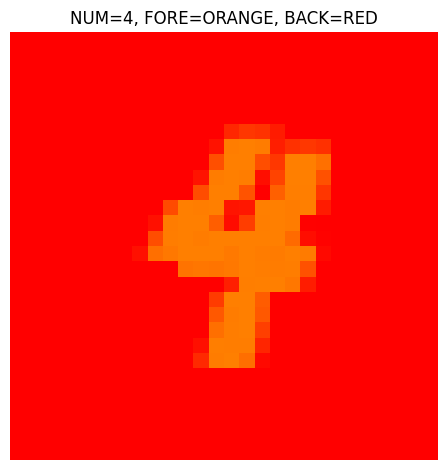

In [ ]:
# 최초 Dataset 확인을 위해 임의의 Sample을 시각화
image_cf_ex = df_image.iloc[0]
label_cf_ex = df_label.iloc[0][0]
image_cf_ex = image_cf_ex.to_numpy()
image_cf_ex =image_cf_ex.reshape(28, 28)

np.random.seed(21) # 색깔의 다양화를 위해 부득이하게 시드를 위와 다르게 설정
pil_image_cf = transforms.ToPILImage()(image_cf_ex)

fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

colored_digit = colorize_digit_customFont(pil_image_cf, fg_color, bg_color)
if image is not None :
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')
  plt.title(f'NUM={label_cf_ex}, FORE={fg_label}, BACK={bg_label}')
  plt.tight_layout()
  plt.show()

**데이터셋으로 변환합니다.**

In [ ]:
# Colored MNIST DataFrame을 생성하고 저장하는 함수 (Custome Font Ver.)
def create_colored_mnist_dataframe_customFont(dataset_sp, dataset_lb) :
  data_list = []     # DataFrame을 만들기 위해 각 Sample을 담을 List 초기화
  fg_list = []
  bg_list = []
  np.random.seed(21) # 결과의 재현성을 위해 랜덤 시드 설정 (색깔의 다양화를 위해 부득이하게 시드를 위와 다르게 설정)

  for idx in range(len(dataset_sp)) :
    # 차례대로 (인덱스 단위로) 데이터 불러오기
    image = dataset_sp.iloc[idx]
    label = dataset_lb.iloc[idx][0]
    image_ctF = image.to_numpy()
    image_ctF = image_ctF.reshape(28, 28)
    pil_image = transforms.ToPILImage()(image_ctF)

    # 전경과 배경 색상을 무작위로 선택
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()
    while bg_color == fg_color : # 전경과 배경이 같은 색상일 경우 다른 색상으로 설정될 때까지 조정
      bg_color, bg_label = get_random_rainbow_color()

    # 숫자 이미지에 색상 적용 후 투명도 제거
    colored_image = colorize_digit_customFont(pil_image, fg_color, bg_color)
    final_image = overlay_digit_on_background(colored_image)

    # DataFrame을 만들기 위한 List에 추가
    data_row = image_to_dataframe(final_image, label)
    data_list.append(data_row)
    fg_list.append(fg_label)
    bg_list.append(bg_label)

  # DataFrame 생성
  columns = ['Label'] + [f'Pixel_{i//3}_{"R" if (i%3 == 0) else ("G" if (i%3 == 1) else "B")}' for i in range(28 * 28 * 3)]
  df_data = pd.DataFrame(data_list, columns=columns)
  df_fg = pd.DataFrame(fg_list, columns=["Foreground"])
  df_bg = pd.DataFrame(bg_list, columns=["Background"])
  return df_data, df_fg, df_bg

In [ ]:
# Custome Font를 이용한 Colored Dataset 생성
x_ctf, y_ctf_fg, y_ctf_bg = create_colored_mnist_dataframe_customFont(df_image, df_label)

# Samle과 Label 분리
y_ctf_lb = x_ctf['Label']
x_ctf = x_ctf.drop(columns=['Label'])

# MNIST 데이터와 동일하게 Min-Max Scaling 진행
x_ctf = x_ctf / 255

In [ ]:
# Sample 확인
x_ctf

,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,Pixel_3_R,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,...,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0
1,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,...,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0
2,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0
3,1.0,1.000000,0.0,1.0,1.000000,0.0,1.0,1.000000,0.0,1.0,...,0.0,1.0,1.000000,0.0,1.0,1.000000,0.0,1.0,1.000000,0.0
4,1.0,1.000000,0.0,1.0,1.000000,0.0,1.0,1.000000,0.0,1.0,...,0.0,1.0,1.000000,0.0,1.0,1.000000,0.0,1.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34765,1.0,0.498039,0.0,1.0,0.498039,0.0,1.0,0.498039,0.0,1.0,...,0.0,1.0,0.498039,0.0,1.0,0.498039,0.0,1.0,0.498039,0.0
34766,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0
34767,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,...,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,0.000000,0.0
34768,1.0,0.498039,0.0,1.0,0.498039,0.0,1.0,0.498039,0.0,1.0,...,0.0,1.0,0.498039,0.0,1.0,0.498039,0.0,1.0,0.498039,0.0


In [ ]:
# Number Label 확인
y_ctf_lb.value_counts()

,count
Label,
4,3477
1,3477
2,3477
6,3477
5,3477
0,3477
8,3477
9,3477
7,3477


In [ ]:
# Foreground Color Label 확인
y_ctf_fg

,Foreground
0,ORANGE
1,BLUE
2,RED
3,BLUE
4,ORANGE
...,...
34765,YELLOW
34766,VIOLET
34767,INDIGO
34768,VIOLET


In [ ]:
# Bakcground Color Label 확인
y_ctf_bg

,Background
0,RED
1,RED
2,GREEN
3,YELLOW
4,YELLOW
...,...
34765,ORANGE
34766,GREEN
34767,RED
34768,ORANGE


### **<font color = 'green'>2-2.</font> 데이터 정제**

**이미지 중 학습에 사용하기 어렵다고 판단되는 이미지들 제거 후 새로 만든 .npz 파일을 이용하여 DataFrame 형태로 데이터를 저장합니다.**

**이미지 제거 작업은 이미지를 직접 확인하여 수작업으로 진행하였습니다.**

In [ ]:
# 정제 작업 후의 이미지들의 Pixel 정보가 담긴 .npz 파일 Load
data2 = np.load('RefinedImageData_UsingCustomFont.npz')

# .npz 파일 내부의 데이터 확인 (.npz 파일 내 저장된 배열 이름 출력)
print(data2.files)

['images', 'labels']


In [ ]:
# Sample과 Label을 DataFrame으로 변환
array_image2 = data2['images']
array_labels2 = data2['labels']

df_image2 = pd.DataFrame(array_image2)
df_label2 = pd.DataFrame(array_labels2)

In [ ]:
# Custome Font를 이용한 Colored Dataset 생성
x_trainCT, y_trainCT_fg, y_trainCT_bg = create_colored_mnist_dataframe_customFont(df_image2, df_label2)

# Samle과 Label 분리 (필요에 따라 진행하기로 결정)
# y_trainCT_lb = x_trainCT['Label']
# x_trainCT = x_trainCT.drop(columns=['Label'])

# MNIST 데이터와 동일하게 Min-Max Scaling 진행 (Sample과 Label 분리 후 진행)
# x_trainCT = x_trainCT / 255

**증강한 데이터는 프로젝트를 진행하며 필요에 따라 기존 데이터셋에 추가하여 사용하고자 합니다.**

## **<font color = 'blue'>3.</font> 모델 선정**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from tqdm import tqdm

In [ ]:
# 진행에 무리 없는 경고 메세지를 출력하지 않도록 설정
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)

**모델 선정은 다음과 같은 절차로 진행하고자 합니다.**

1. **모델 <font color = 'orange'>후보군 설정</font>**
2. **각 모델의 <font color = 'orange'>최적의 하이퍼파라미터</font> 탐색**
3. **최적의 하이퍼파라미터로 설정된 <font color = 'orange'>모델 간 성능 비교</font>**
4. **최종 모델 <font color = 'orange'>선택</font>**

**모델 후보군은 다음과 같이 선정하였습니다.**

> **선정 기준**

**MNIST 데이터셋을 분류하기에 <font color = 'red'>적합한 특징</font>을 가진 모델**

> **<font color = 'red'>적합한 특징</font>**

**<font color = 'green'>공통</font>**

**다중 클래스 분류와 비선형 데이터에 적합**

**<font color = 'green'>거리 기반 모델</font> (K-NN)**

**단순하고 직관적인 알고리즘, 학습 불필요 (분류 작업만 수행) = 시간 성능 우수**

**<font color = 'green'>트리, 앙상블 기반 모델</font> (DT, RF, ...)**

**원활한 중요 Feature 집중 학습, 강력한 일반화 성능**

> **선정 후보군**

**K-Nearest Neighbors**

**Decision Tree**

**Random Forest**

**Gradient Boosting**

**Extra Trees**

**<font color = 'red'>[ ! ]</font> 최적의 하이퍼파라미터 탐색 시에는 동일 데이터셋을 이용하여 비교함으로써 경향 파악이 충분하고, 시간과 자원의 효율성을 확보하기 위해서 증강 없는 Colored MNIST를 축소하여 사용하였습니다.**

**<font color = 'red'>[ ! ]</font> 모델에 따라 학습과 평가에 너무 오랜 시간이 걸리는 문제와 하나의 코드 파일을 이용하여 여러 명이 동시에 하이퍼파라미터 탐색 시 원활한 탐색의 어려움 등의 문제가 있어 사본을 이용하여 각자 탐색 및 성능 평가를 진행하였습니다. 이로 인해, 제출 코드 파일에는 하이퍼파라미터 탐색 코드 결과 셀이 없는 상태로 제출하게 되었습니다. 탐색 결과는 보고서에서 표와 탐색 과정 사진 등으로 정리하여 말씀드리겠습니다.**

In [ ]:
# 하이퍼파라미터 탐색에 사용하기 위한 축소된 데이터셋

# Train / Validation Sample
x_train_mms_hp = x_train_mms[5000:37000]
x_valid_mms_hp = x_valid_mms[0:8000]

# Train / Validation Label
y_train_lb_hp = y_train_lb[5000:37000]
y_train_fg_hp = y_train_fg[5000:37000]
y_train_bg_hp = y_train_bg[5000:37000]

y_valid_lb_hp = y_valid_lb[0:8000]
y_valid_fg_hp = y_valid_fg[0:8000]
y_valid_bg_hp = y_valid_bg[0:8000]

### **<font color = 'blue'>3-1.</font> 숫자 분류기 (Number)**

#### **<font color = 'blue'>3-1-1.</font> 최적의 하이퍼파라미터 탐색**

> **K-Nearest Neighbors**

In [ ]:
# K-Nearest Neighbor 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
    'weights' : ["uniform", "distance"],
    'metric': ['euclidean', 'manhattan']
}
# K-NN 모델 설정
knn = KNeighborsClassifier()

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    knn.set_params(**params)
    knn.fit(x_train_mms_hp, y_train_lb_hp)
    current_score = knn.score(x_valid_mms_hp, y_valid_lb_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score :
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of K-NN for Number Classification : {best_params}")

> **Decision Tree**

In [ ]:
# Decision Tree 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_dt = {
    'max_depth' : [15, 20, 30, 50],
    'max_features' : ['log2', 'sqrt'],
    'min_samples_split' : [1, 2, 4, 8],
    'min_samples_leaf' : [1, 2, 4, 8]
}

# Decision Tree 모델 설정
dt = DecisionTreeClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_dt))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    dt.set_params(**params)
    dt.fit(x_train_mms_hp, y_train_lb_hp)
    current_score = dt.score(x_valid_mms_hp, y_valid_lb_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Decision Tree for Number Classification : {best_params}")

> **Random Forest**

In [ ]:
# Random Forest 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_rf = {
    'n_estimators' : [200, 300, 400],
    'max_depth' : [3, 5, 7, 10, 20, 30],
    'min_samples_split' : [2, 5, 10, 20]
}

# Random Forest 모델 설정
rf = RandomForestClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    rf.set_params(**params)
    rf.fit(x_train_mms_hp, y_train_lb_hp)
    current_score = rf.score(x_valid_mms_hp, y_valid_lb_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Random Forest for Number Classification : {best_params}")

> **Gradient Boosting**

In [ ]:
# Gradient Boosting 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_gb = {
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'max_depth' : [2, 3, 5]
}

# Gradient Boosting 모델 설정
gb = GradientBoostingClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_gb))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    gb.set_params(**params)
    gb.fit(x_train_mms_hp, y_train_lb_hp)
    current_score = gb.score(x_valid_mms_hp, y_valid_lb_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Gradient Boosting for Number Classification : {best_params}")

> **Extra Trees**

In [ ]:
# Extra Trees 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_ext = {
    'n_estimators' : [100, 200, 400],
    'max_depth' : [3, 7, 10],
    'min_samples_split' : [10, 100, 1000],
    'max_feature' : ['sqrt', 'log2']
}

# Extra Trees 모델 설정
ext = ExtraTreesClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_ext))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    ext.set_params(**params)
    ext.fit(x_train_mms_hp, y_train_lb_hp)
    current_score = ext.score(x_valid_mms_hp, y_valid_lb_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Extra Trees for Number Classification : {best_params}")

#### **<font color = 'blue'>3-1-2.</font> 모델 간 성능 비교**

> **K-Nearest Neighbors**

In [ ]:
test_model = KNeighborsClassifier(metric='manhattan',n_neighbors=3, weights='distance')
test_modelName = 'K-Nearest Neighbors for Number Classification'

test_model.fit(x_train_mms, y_train_lb)
y_pred_lb = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : K-Nearest Neighbors for Number Classification
Accuracy : 0.8942
Classification Report :
              precision    recall  f1-score   support

           0     0.9434    0.9765    0.9597      1194
           1     0.8057    0.9945    0.8902      1272
           2     0.9747    0.8361    0.9001      1196
           3     0.8846    0.9074    0.8959      1242
           4     0.9123    0.8500    0.8801      1187
           5     0.9018    0.8459    0.8730      1097
           6     0.9379    0.9684    0.9529      1170
           7     0.8717    0.9167    0.8936      1297
           8     0.9493    0.7821    0.8577      1198
           9     0.8133    0.8509    0.8317      1147

    accuracy                         0.8942     12000
   macro avg     0.8995    0.8929    0.8935     12000
weighted avg     0.8988    0.8942    0.8938     12000



> **Decision Tree**

In [ ]:
test_model = DecisionTreeClassifier(max_depth=50, max_features='sqrt',
                                    min_samples_split=2, min_samples_leaf=4, random_state=42)
test_modelName = 'Decision Tree for Number Classification'

test_model.fit(x_train_mms, y_train_lb)
y_pred_lb = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Decision Tree for Number Classification
Accuracy : 0.6773
Classification Report :
              precision    recall  f1-score   support

           0     0.7452    0.8057    0.7742      1194
           1     0.8587    0.9175    0.8871      1272
           2     0.6285    0.6522    0.6401      1196
           3     0.6081    0.6546    0.6305      1242
           4     0.6289    0.6596    0.6439      1187
           5     0.5468    0.5223    0.5343      1097
           6     0.7169    0.6709    0.6932      1170
           7     0.7431    0.7448    0.7439      1297
           8     0.5998    0.5292    0.5623      1198
           9     0.6465    0.5789    0.6109      1147

    accuracy                         0.6773     12000
   macro avg     0.6722    0.6736    0.6720     12000
weighted avg     0.6748    0.6773    0.6752     12000



> **Random Forest**

In [ ]:
test_model = RandomForestClassifier(n_estimators=400, max_depth=30, min_samples_split=2, random_state=42)
test_modelName = 'Random Forest Classifier for Number Classification'

test_model.fit(x_train_mms, y_train_lb)
y_pred_lb = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Random Forest Classifier for Number Classification
Accuracy : 0.9413
Classification Report :
              precision    recall  f1-score   support

           0     0.9592    0.9832    0.9711      1194
           1     0.9521    0.9843    0.9679      1272
           2     0.9510    0.9247    0.9377      1196
           3     0.9286    0.9316    0.9301      1242
           4     0.9400    0.9377    0.9388      1187
           5     0.9439    0.9043    0.9236      1097
           6     0.9518    0.9786    0.9650      1170
           7     0.9538    0.9383    0.9460      1297
           8     0.9378    0.9065    0.9219      1198
           9     0.8932    0.9189    0.9059      1147

    accuracy                         0.9413     12000
   macro avg     0.9411    0.9408    0.9408     12000
weighted avg     0.9414    0.9413    0.9412     12000



> **Gradient Boosting**

In [ ]:
test_model = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, random_state=42)
test_modelName = 'Gradient Boosting for Number Classification'

test_model.fit(x_train_mms, y_train_lb)
y_pred_lb = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Gradient Boosting for Number Classification
Accuracy : 0.8334
Classification Report :
              precision    recall  f1-score   support

           0     0.8780    0.9338    0.9050      1194
           1     0.8564    0.9568    0.9038      1272
           2     0.8404    0.7968    0.8180      1196
           3     0.8153    0.7963    0.8057      1242
           4     0.8370    0.8433    0.8401      1187
           5     0.8017    0.6892    0.7412      1097
           6     0.8437    0.8906    0.8665      1170
           7     0.8499    0.8689    0.8593      1297
           8     0.8127    0.7387    0.7739      1198
           9     0.7809    0.7986    0.7897      1147

    accuracy                         0.8334     12000
   macro avg     0.8316    0.8313    0.8303     12000
weighted avg     0.8323    0.8334    0.8317     12000



> **Extra Trees**

In [ ]:
test_model = ExtraTreesClassifier(n_estimators=400, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
test_modelName = 'Extra Trees for Number Classification'

test_model.fit(x_train_mms, y_train_lb)
y_pred_lb = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_lb, y_pred_lb)
report = classification_report(y_valid_lb, y_pred_lb, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Number Classification
Accuracy : 0.9429
Classification Report :
              precision    recall  f1-score   support

           0     0.9646    0.9807    0.9726      1194
           1     0.9458    0.9874    0.9662      1272
           2     0.9576    0.9247    0.9409      1196
           3     0.9237    0.9461    0.9348      1242
           4     0.9502    0.9318    0.9409      1187
           5     0.9493    0.9052    0.9267      1097
           6     0.9441    0.9821    0.9627      1170
           7     0.9540    0.9429    0.9484      1297
           8     0.9539    0.8990    0.9257      1198
           9     0.8877    0.9233    0.9051      1147

    accuracy                         0.9429     12000
   macro avg     0.9431    0.9423    0.9424     12000
weighted avg     0.9433    0.9429    0.9428     12000



#### **<font color = 'blue'>3-1-3.</font> 최종 모델 선정**

**성능 비교 결과, Extra Trees 모델을 선정하였습니다.**

> **모델**

**Extra Trees**

> **하이퍼파라미터**

**max_depth = 30**

**max_features = 'sqrt'**

**min_samples_split = 2**

**n_estimators = 400**

> **성능**

**정확도 : 0.9429**

**Precision : 0.9433**

**Recall : 0.9429**

**F1-Score : 0.9428**

### **<font color = 'blue'>3-2.</font> 전경색 분류기 (Foreground Color)**

#### **<font color = 'blue'>3-2-1.</font> 최적의 하이퍼파라미터 탐색**

> **K-Nearest Neighbors**

In [ ]:
# K-Nearest Neighbor 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
    'weights' : ["uniform", "distance"],
    'metric': ['euclidean', 'manhattan']
}
# KNN 모델 설정
knn = KNeighborsClassifier()

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    knn.set_params(**params)
    knn.fit(x_train_mms_hp, y_train_fg_hp)
    current_score = knn.score(x_valid_mms_hp, y_valid_fg_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score :
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of K-NN for Foreground Color Classification : {best_params}")

> **Decision Tree**

In [ ]:
# Decision Tree 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_dt = {
    'min_samples_split' : [10, 20, 50, 100],
    'min_samples_leaf' : [1, 2, 4]
}

# Decision Tree 모델 설정
dt = DecisionTreeClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_dt))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    dt.set_params(**params)
    dt.fit(x_train_mms_hp, y_train_fg_hp)
    current_score = dt.score(x_valid_mms_hp, y_valid_fg_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Decision Tree for Foreground Color Classification : {best_params}")

> **Random Forest**

In [ ]:
# Random Forest 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_rf = {
    'n_estimators' : [200, 300],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : [2, 5, 10, 20]
}

# Random Forest 모델 설정
rf = RandomForestClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    rf.set_params(**params)
    rf.fit(x_train_mms_hp, y_train_fg_hp)
    current_score = rf.score(x_valid_mms_hp, y_valid_fg_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Random Forest for Foreground Color Classification : {best_params}")

> **Gradient Boosting**

In [ ]:
# Gradient Boosting 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_gb = {
    'learning_rate' : [0.05, 0.1, 0.2],
    'max_depth' : [2, 3]
}

# Gradient Boosting 모델 설정
gb = GradientBoostingClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_gb))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    gb.set_params(**params)
    gb.fit(x_train_mms_hp, y_train_fg_hp)
    current_score = gb.score(x_valid_mms_hp, y_valid_fg_hp)
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Gradient Boosting for Foreground Color Classification : {best_params}")

> **Extra Tree**

In [ ]:
# Extra Trees 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_ext = {
    'n_estimators' : [100, 200, 300, 400],
    'max_depth' : [3, 7, 10],
    'min_samples_split' : [10, 100, 1000],
    'max_feature' : ['sqrt', 'log2']
}

# Gradient Boosting 모델 설정
ext = ExtraTreesClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_ext))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    ext.set_params(**params)
    ext.fit(x_train_mms_hp, y_train_fg_hp)
    current_score = ext.score(x_valid_mms_hp, y_valid_fg_hp)
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Extra Trees for Foreground Color Classification : {best_params}")

#### **<font color = 'blue'>3-2-2.</font> 모델 간 성능 비교**

> **K-Nearest Neighbors**

In [ ]:
test_model = KNeighborsClassifier(metric='manhattan',n_neighbors=3, weights='distance')
test_modelName = 'K-Nearest Neighbors for Foreground Color Classification'

test_model.fit(x_train_mms, y_train_fg)
y_pred_fg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_fg, y_pred_fg)
report = classification_report(y_valid_fg, y_pred_fg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : K-Nearest Neighbors for Foreground Color Classification
Accuracy : 0.9287
Classification Report :
              precision    recall  f1-score   support

        BLUE     0.9954    0.8682    0.9275      1753
       GREEN     0.9982    0.9768    0.9874      1679
      INDIGO     0.8718    0.9857    0.9253      1683
      ORANGE     0.8234    0.9448    0.8799      1722
         RED     0.9516    0.9210    0.9361      1773
      VIOLET     0.9234    0.9457    0.9344      1695
      YELLOW     0.9760    0.8619    0.9154      1695

    accuracy                         0.9287     12000
   macro avg     0.9342    0.9292    0.9294     12000
weighted avg     0.9344    0.9287    0.9293     12000



> **Decision Tree**

In [ ]:
test_model = DecisionTreeClassifier(max_depth=50, max_features='sqrt',
                                    min_samples_split=4, min_samples_leaf=4, random_state=42)
test_modelName = 'Decision Tree for Foreground Color Classification'

test_model.fit(x_train_mms, y_train_fg)
y_pred_fg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_fg, y_pred_fg)
report = classification_report(y_valid_fg, y_pred_fg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Decision Tree for Foreground Color Classification
Accuracy : 0.9639
Classification Report :
              precision    recall  f1-score   support

        BLUE     0.9605    0.9572    0.9589      1753
       GREEN     0.9737    0.9696    0.9717      1679
      INDIGO     0.9524    0.9632    0.9578      1683
      ORANGE     0.9655    0.9739    0.9696      1722
         RED     0.9694    0.9836    0.9765      1773
      VIOLET     0.9601    0.9516    0.9559      1695
      YELLOW     0.9657    0.9475    0.9565      1695

    accuracy                         0.9639     12000
   macro avg     0.9639    0.9638    0.9638     12000
weighted avg     0.9639    0.9639    0.9639     12000



> **Random Forest**

In [ ]:
test_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=2, random_state=42)
test_modelName = 'Random Forest Classifier for Foreground Color Classification'

test_model.fit(x_train_mms, y_train_fg)
y_pred_fg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_fg, y_pred_fg)
report = classification_report(y_valid_fg, y_pred_fg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Random Forest Classifier for Foreground Color Classification
Accuracy : 0.9992
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    0.9994    0.9997      1753
       GREEN     1.0000    0.9988    0.9994      1679
      INDIGO     0.9982    0.9994    0.9988      1683
      ORANGE     0.9971    1.0000    0.9986      1722
         RED     1.0000    0.9983    0.9992      1773
      VIOLET     0.9994    1.0000    0.9997      1695
      YELLOW     1.0000    0.9988    0.9994      1695

    accuracy                         0.9992     12000
   macro avg     0.9992    0.9993    0.9992     12000
weighted avg     0.9993    0.9992    0.9993     12000



> **Gradient Boosting**

In [ ]:
test_model = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, random_state=42)
test_modelName = 'Gradient Boosting for Foreground Color Classification'

test_model.fit(x_train_mms, y_train_fg)
y_pred_fg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_fg, y_pred_fg)
report = classification_report(y_valid_fg, y_pred_fg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Gradient Boosting for Foreground Color Classification
Accuracy : 0.9982
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    0.9989    0.9994      1753
       GREEN     0.9994    0.9988    0.9991      1679
      INDIGO     0.9970    0.9958    0.9964      1683
      ORANGE     0.9977    0.9994    0.9985      1722
         RED     0.9983    0.9983    0.9983      1773
      VIOLET     0.9947    0.9988    0.9968      1695
      YELLOW     1.0000    0.9971    0.9985      1695

    accuracy                         0.9982     12000
   macro avg     0.9982    0.9982    0.9982     12000
weighted avg     0.9982    0.9982    0.9982     12000



> **Extra Trees**

In [ ]:
test_model = ExtraTreesClassifier(n_estimators=300, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
test_modelName = 'Extra Trees for Foreground Color Classification'

test_model.fit(x_train_mms, y_train_fg)
y_pred_fg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_fg, y_pred_fg)
report = classification_report(y_valid_fg, y_pred_fg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Foreground Color Classification
Accuracy : 0.9999
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    0.9994    0.9997      1753
       GREEN     1.0000    1.0000    1.0000      1679
      INDIGO     0.9994    1.0000    0.9997      1683
      ORANGE     1.0000    1.0000    1.0000      1722
         RED     1.0000    1.0000    1.0000      1773
      VIOLET     1.0000    1.0000    1.0000      1695
      YELLOW     1.0000    1.0000    1.0000      1695

    accuracy                         0.9999     12000
   macro avg     0.9999    0.9999    0.9999     12000
weighted avg     0.9999    0.9999    0.9999     12000



#### **<font color = 'blue'>3-2-3.</font> 최종 모델 선정**

**성능 비교 결과, Extra Trees 모델을 선정하였습니다.**

> **모델**

**Extra Trees**

> **하이퍼파라미터**

**max_depth = 30**

**max_features = 'sqrt'**

**min_samples_split = 2**

**n_estimators = 300**

> **성능**

**정확도 : 0.9999**

**Precision : 0.9999**

**Recall : 0.9999**

**F1-Score : 0.9999**

### **<font color = 'blue'>3-3.</font> 배경색 분류기 (Background Color)**

#### **<font color = 'blue'>3-3-1.</font> 최적의 하이퍼파라미터 탐색**

> **K-Nearest Neighbors**

In [ ]:
# K-Nearest Neighbor 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
    'weights' : ["uniform", "distance"],
    'metric': ['euclidean', 'manhattan']
}
# KNN 모델 설정
knn = KNeighborsClassifier()

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    knn.set_params(**params)
    knn.fit(x_train_mms_hp, y_train_bg_hp)
    current_score = knn.score(x_valid_mms_hp, y_valid_bg_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score :
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of K-NN for Background Color Classification : {best_params}")

> **Decision Tree**

In [ ]:
# Decision Tree 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_dt = {
    'min_samples_split' : [10, 20, 50, 100],
    'min_samples_leaf' : [1, 2, 4]
}

# Decision Tree 모델 설정
dt = DecisionTreeClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_dt))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    dt.set_params(**params)
    dt.fit(x_train_mms_hp, y_train_bg_hp)
    current_score = dt.score(x_valid_mms_hp, y_valid_bg_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Decision Tree for Background Color Classification : {best_params}")

> **Random Forest**

In [ ]:
# Random Forest 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_rf = {
    'n_estimators' : [200, 300],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : [2, 5, 10, 20]
}

# Random Forest 모델 설정
rf = RandomForestClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    rf.set_params(**params)
    rf.fit(x_train_mms_hp, y_train_bg_hp)
    current_score = rf.score(x_valid_mms_hp, y_valid_bg_hp)
    print("")
    print(f"{params}'s Accuracy : {current_score}")
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Random Forest for Background Color Classification : {best_params}")

> **Gradient Boosting**

In [ ]:
# Gradient Boosting 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_gb = {
    'learning_rate' : [0.05, 0.1, 0.2],
    'max_depth' : [2, 3]
}

# Gradient Boosting 모델 설정
gb = GradientBoostingClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_gb))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    gb.set_params(**params)
    gb.fit(x_train_mms_hp, y_train_bg_hp)
    current_score = gb.score(x_valid_mms_hp, y_valid_bg_hp)
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Gradient Boosting for Background Color Classification : {best_params}")

> **Extra Trees**

In [ ]:
# Extra Trees 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid_ext = {
    'n_estimators' : [100, 200, 400],
    'max_depth' : [3, 7, 10],
    'min_samples_split' : [10, 100, 1000],
    'max_feature' : ['sqrt', 'log2']
}

# Gradient Boosting 모델 설정
ext = ExtraTreesClassifier(random_state=42)

# 진행율 표시를 위한 ParameterGrid, tqdm 설정
parameter_grid = list(ParameterGrid(param_grid_ext))
progress_bar = tqdm(total=len(parameter_grid))

# 각 Hyperparameter별 성능 비교 후 최적의 Hyperparameter 추출
best_score = 0
best_params = None
for params in parameter_grid :
    ext.set_params(**params)
    ext.fit(x_train_mms_hp, y_train_bg_hp)
    current_score = ext.score(x_valid_mms_hp, y_valid_bg_hp)
    if current_score > best_score:
        best_score = current_score
        best_params = params
    progress_bar.update(1)
progress_bar.close()

# 최적의 하이퍼파라미터 출력 및 해당 하이퍼파라미터로 모델 설정
print("")
print(f"Best Hyperparameters of Extra Trees for Background Color Classification : {best_params}")

#### **<font color = 'blue'>3-3-2.</font> 모델 간 성능 비교**

> **K-Nearest Neighbors**

In [ ]:
test_model = KNeighborsClassifier(metric='manhattan',n_neighbors=3, weights='distance')
test_modelName = 'K-Nearest Neighbors for Background Color Classification'

test_model.fit(x_train_mms, y_train_bg)
y_pred_bg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_bg, y_pred_bg)
report = classification_report(y_valid_bg, y_pred_bg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : K-Nearest Neighbors for Background Color Classification
Accuracy : 1.0000
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    1.0000    1.0000      1733
       GREEN     1.0000    1.0000    1.0000      1700
      INDIGO     1.0000    1.0000    1.0000      1716
      ORANGE     1.0000    1.0000    1.0000      1705
         RED     1.0000    1.0000    1.0000      1705
      VIOLET     1.0000    1.0000    1.0000      1720
      YELLOW     1.0000    1.0000    1.0000      1721

    accuracy                         1.0000     12000
   macro avg     1.0000    1.0000    1.0000     12000
weighted avg     1.0000    1.0000    1.0000     12000



> **Decision Tree**

In [ ]:
test_model = DecisionTreeClassifier(max_depth=40, max_features='sqrt',
                                    min_samples_split=4, min_samples_leaf=4, random_state=42)
test_modelName = 'Decision Tree for Background Color Classification'

test_model.fit(x_train_mms, y_train_bg)
y_pred_bg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_bg, y_pred_bg)
report = classification_report(y_valid_bg, y_pred_bg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Decision Tree for Background Color Classification
Accuracy : 0.9999
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    1.0000    1.0000      1733
       GREEN     1.0000    1.0000    1.0000      1700
      INDIGO     0.9994    1.0000    0.9997      1716
      ORANGE     1.0000    1.0000    1.0000      1705
         RED     1.0000    1.0000    1.0000      1705
      VIOLET     1.0000    0.9994    0.9997      1720
      YELLOW     1.0000    1.0000    1.0000      1721

    accuracy                         0.9999     12000
   macro avg     0.9999    0.9999    0.9999     12000
weighted avg     0.9999    0.9999    0.9999     12000



> **Random Forest**

In [ ]:
test_model = RandomForestClassifier(n_estimators = 200, max_depth = 3, min_samples_split = 2, random_state=42)
test_modelName = 'Random Forest Classifier for Background Color Classification'

test_model.fit(x_train_mms, y_train_bg)
y_pred_bg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_bg, y_pred_bg)
report = classification_report(y_valid_bg, y_pred_bg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Random Forest Classifier for Background Color Classification
Accuracy : 1.0000
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    1.0000    1.0000      1733
       GREEN     1.0000    1.0000    1.0000      1700
      INDIGO     1.0000    1.0000    1.0000      1716
      ORANGE     1.0000    1.0000    1.0000      1705
         RED     1.0000    1.0000    1.0000      1705
      VIOLET     1.0000    1.0000    1.0000      1720
      YELLOW     1.0000    1.0000    1.0000      1721

    accuracy                         1.0000     12000
   macro avg     1.0000    1.0000    1.0000     12000
weighted avg     1.0000    1.0000    1.0000     12000



> **Gradient Boosting**

In [ ]:
test_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, random_state=42)
test_modelName = 'Gradient Boosting for Background Color Classification'

test_model.fit(x_train_mms, y_train_bg)
y_pred_bg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_bg, y_pred_bg)
report = classification_report(y_valid_bg, y_pred_bg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Gradient Boosting for Background Color Classification
Accuracy : 0.9998
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    1.0000    1.0000      1733
       GREEN     1.0000    1.0000    1.0000      1700
      INDIGO     1.0000    1.0000    1.0000      1716
      ORANGE     0.9994    1.0000    0.9997      1705
         RED     1.0000    0.9988    0.9994      1705
      VIOLET     1.0000    1.0000    1.0000      1720
      YELLOW     0.9994    1.0000    0.9997      1721

    accuracy                         0.9998     12000
   macro avg     0.9998    0.9998    0.9998     12000
weighted avg     0.9998    0.9998    0.9998     12000



> **Extra Trees**

In [ ]:
test_model = ExtraTreesClassifier(n_estimators=300, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
test_modelName = 'Extra Trees for Background Color Classification'

test_model.fit(x_train_mms, y_train_bg)
y_pred_bg = test_model.predict(x_valid_mms)
accuracy = accuracy_score(y_valid_bg, y_pred_bg)
report = classification_report(y_valid_bg, y_pred_bg, digits=4)
print(f"Model : {test_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Background Color Classification
Accuracy : 1.0000
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    1.0000    1.0000      1733
       GREEN     1.0000    1.0000    1.0000      1700
      INDIGO     1.0000    1.0000    1.0000      1716
      ORANGE     1.0000    1.0000    1.0000      1705
         RED     1.0000    1.0000    1.0000      1705
      VIOLET     1.0000    1.0000    1.0000      1720
      YELLOW     1.0000    1.0000    1.0000      1721

    accuracy                         1.0000     12000
   macro avg     1.0000    1.0000    1.0000     12000
weighted avg     1.0000    1.0000    1.0000     12000



#### **<font color = 'blue'>3-3-3.</font> 최종 모델 선정**

**성능 비교 결과, XXX 모델을 선정하였습니다.**

> **모델**

**Extra Trees**

> **하이퍼파라미터**

**max_depth = 30**

**max_features = 'sqrt'**

**min_samples_split = 2**

**n_estimators = 300**

> **성능**

**정확도 : 1.0000**

**Precision : 1.0000**

**Recall : 1.0000**

**F1-Score : 1.0000**

> **비고**

**K-NN 또한 동일한 지표를 보였으나 시간적인 요소에서 Extra Trees 모델이 우수하여 선정**

## **<font color = 'navy'>4.</font> 선정 모델 성능 평가**

> **Number Classification**

In [ ]:
final_model = ExtraTreesClassifier(n_estimators=400, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
final_modelName = 'Extra Trees for Number Classification using Test Set'

final_model.fit(x_train_mms, y_train_lb)
y_pred_lb = final_model.predict(x_test_mms)
accuracy = accuracy_score(y_test_lb, y_pred_lb)
report = classification_report(y_test_lb, y_pred_lb, digits=4)
print(f"Model : {final_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Number Classification using Test Set
Accuracy : 0.9368
Classification Report :
              precision    recall  f1-score   support

           0     0.9387    0.9837    0.9606       980
           1     0.9598    0.9877    0.9735      1135
           2     0.9425    0.9205    0.9314      1032
           3     0.9181    0.9327    0.9253      1010
           4     0.9351    0.9246    0.9299       982
           5     0.9502    0.8991    0.9240       892
           6     0.9359    0.9603    0.9480       958
           7     0.9556    0.9212    0.9381      1028
           8     0.9338    0.9117    0.9226       974
           9     0.8982    0.9177    0.9078      1009

    accuracy                         0.9368     10000
   macro avg     0.9368    0.9359    0.9361     10000
weighted avg     0.9370    0.9368    0.9367     10000



> **Foreground Classification**

In [ ]:
final_model = ExtraTreesClassifier(n_estimators=300, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
final_modelName = 'Extra Trees for Foreground Color Classification using Test Set'

final_model.fit(x_train_mms, y_train_fg)
y_pred_fg = final_model.predict(x_test_mms)
accuracy = accuracy_score(fg_test, y_pred_fg)
report = classification_report(fg_test, y_pred_fg, digits=4)
print(f"Model : {final_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Foreground Color Classification using Test Set
Accuracy : 0.9995
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    0.9993    0.9997      1440
       GREEN     1.0000    1.0000    1.0000      1411
      INDIGO     0.9993    1.0000    0.9997      1448
      ORANGE     0.9980    1.0000    0.9990      1476
         RED     1.0000    1.0000    1.0000      1421
      VIOLET     0.9993    0.9993    0.9993      1430
      YELLOW     1.0000    0.9978    0.9989      1374

    accuracy                         0.9995     10000
   macro avg     0.9995    0.9995    0.9995     10000
weighted avg     0.9995    0.9995    0.9995     10000



> **Background Classification**

In [ ]:
final_model = ExtraTreesClassifier(n_estimators=300, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
final_modelName = 'Extra Trees for Background Color Classification using Test Set'

final_model.fit(x_train_mms, y_train_bg)
y_pred_bg = final_model.predict(x_test_mms)
accuracy = accuracy_score(bg_test, y_pred_bg)
report = classification_report(bg_test, y_pred_bg, digits=4)
print(f"Model : {final_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Background Color Classification using Test Set
Accuracy : 1.0000
Classification Report :
              precision    recall  f1-score   support

        BLUE     1.0000    1.0000    1.0000      1479
       GREEN     1.0000    1.0000    1.0000      1464
      INDIGO     1.0000    1.0000    1.0000      1357
      ORANGE     1.0000    1.0000    1.0000      1422
         RED     1.0000    1.0000    1.0000      1428
      VIOLET     1.0000    1.0000    1.0000      1460
      YELLOW     1.0000    1.0000    1.0000      1390

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000



> **<font color = 'blue'>Number</font> Classification**

**Accuracy : 0.9368**

**F1-Score : 0.9367**

> **<font color = 'blue'>Foreground Color</font> Classification**

**Accuracy : 0.9995**

**F1-Score : 0.9995**

> **<font color = 'blue'>Background Color</font> Classification**

**Accuracy : 1.0000**

**F1-Score : 1.0000**

## **<font color = 'purple'>5.</font> 오류 분석을 통한 모델 최적화**

**전경색, 배경색 분류 작업은 매우 잘 수행되고 있어 숫자 분류 모델의 오류 분석에 중점을 두고자 합니다.**

> **1번째 Confusion Matrix**

**모델이 오분류하는 데이터를 위주로 최적화를 진행하고자 합니다.**

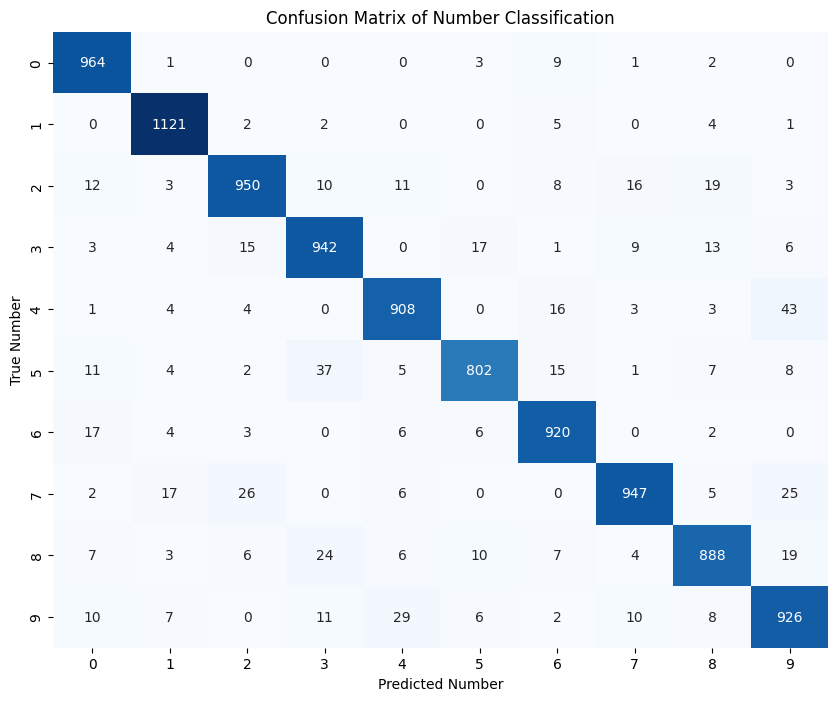

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 생성 및 시각화
conf_matrix = confusion_matrix(y_test_lb, y_pred_lb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of Number Classification")
plt.xlabel("Predicted Number")
plt.ylabel("True Number")
plt.show()

In [ ]:
# 잘못 분류된 비율이 많은 '4' 데이터 추가
x_train2 = x_trainCT[x_trainCT['Label'] == 4].head(1000)
y_train_lb2 = x_train2['Label']
x_train2 = x_train2.drop(columns=['Label'])
x_train2 = x_train2 / 255

In [ ]:
# 잘못 분류된 비율이 많은 '5' 데이터 추가
x_train3 = x_trainCT[x_trainCT['Label'] == 5].head(1000)
y_train_lb3 = x_train3['Label']
x_train3 = x_train3.drop(columns=['Label'])
x_train3 = x_train3 / 255

In [ ]:
# 새로운 Train Set Sample 구성
new_trainb = pd.concat([x_train_mms, x_train2], axis=0, ignore_index=True)
new_train = pd.concat([new_trainb, x_train3], axis=0, ignore_index=True)
new_train

,Pixel_0_R,Pixel_0_G,Pixel_0_B,Pixel_1_R,Pixel_1_G,Pixel_1_B,Pixel_2_R,Pixel_2_G,Pixel_2_B,Pixel_3_R,...,Pixel_780_B,Pixel_781_R,Pixel_781_G,Pixel_781_B,Pixel_782_R,Pixel_782_G,Pixel_782_B,Pixel_783_R,Pixel_783_G,Pixel_783_B
0,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000
1,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
2,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,...,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000
3,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
4,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,...,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000,1.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,...,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0,1.000000
49996,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,...,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451,0.580392,0.0,0.827451
49997,0.294118,0.0,0.509804,0.294118,0.0,0.509804,0.294118,0.0,0.509804,0.294118,...,0.509804,0.294118,0.0,0.509804,0.294118,0.0,0.509804,0.294118,0.0,0.509804
49998,0.294118,0.0,0.509804,0.294118,0.0,0.509804,0.294118,0.0,0.509804,0.294118,...,0.509804,0.294118,0.0,0.509804,0.294118,0.0,0.509804,0.294118,0.0,0.509804


In [ ]:
# 새로운 Train Set Label 구성
new_trainyb = pd.concat([y_train_lb, y_train_lb2], axis=0, ignore_index=True)
new_trainy = pd.concat([new_trainyb, y_train_lb3], axis=0, ignore_index=True)
new_trainy

,Label
0,5
1,0
2,4
3,1
4,9
...,...
49995,5
49996,5
49997,5
49998,5


In [ ]:
final_model = ExtraTreesClassifier(n_estimators=400, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
final_modelName = 'Extra Trees for Number Classification using Additional Dataset'

final_model.fit(new_train, new_trainy)
y_pred_lb = final_model.predict(x_test_mms)
accuracy = accuracy_score(y_test_lb, y_pred_lb)
report = classification_report(y_test_lb, y_pred_lb, digits=4)
print(f"Model : {final_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Number Classification using Additional Dataset
Accuracy : 0.9383
Classification Report :
              precision    recall  f1-score   support

           0     0.9449    0.9806    0.9624       980
           1     0.9671    0.9850    0.9760      1135
           2     0.9494    0.9264    0.9377      1032
           3     0.9266    0.9248    0.9257      1010
           4     0.9066    0.9582    0.9317       982
           5     0.9125    0.9238    0.9181       892
           6     0.9454    0.9572    0.9512       958
           7     0.9592    0.9154    0.9368      1028
           8     0.9390    0.9014    0.9199       974
           9     0.9269    0.9049    0.9157      1009

    accuracy                         0.9383     10000
   macro avg     0.9378    0.9378    0.9375     10000
weighted avg     0.9385    0.9383    0.9382     10000



**이전 모델에 비해 0.002의 성능 향상을 확인하였습니다.**

> **2번째 Confusion Matrix**

**모델이 오분류하는 데이터뿐만 아니라 Class의 개수도 조정하고자 합니다.**

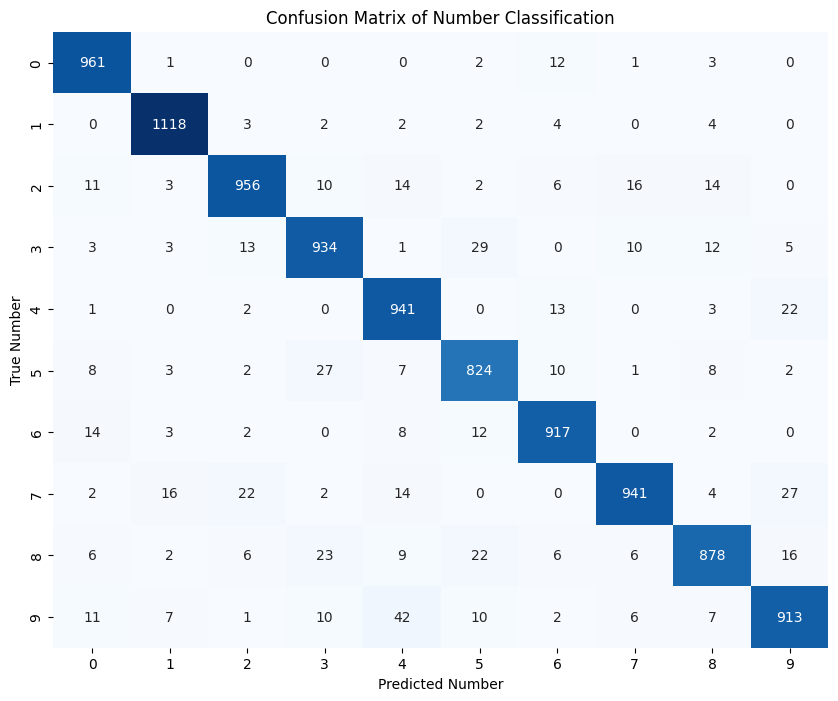

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 생성 및 시각화
conf_matrix = confusion_matrix(y_test_lb, y_pred_lb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of Number Classification")
plt.xlabel("Predicted Number")
plt.ylabel("True Number")
plt.show()

In [ ]:
# 현재 Train Set의 Class 개수 확인
new_trainy.value_counts()

,count
Label,
4,5655
1,5470
5,5324
7,4968
3,4889
9,4802
2,4762
6,4748
0,4729


In [ ]:
# 추가된 '4'로 인해 잘못 분류된 비율이 많은 '9' 데이터 추가
x_train4 = x_trainCT[x_trainCT['Label'] == 9].head(500)
y_train_lb4 = x_train4['Label']
x_train4 = x_train4.drop(columns=['Label'])
x_train4 = x_train4 / 255

**단순히 오분류된 클래스의 데이터만 추가하면 위 상황이 반복될 것으로 판단하여 데이터의 균형을 맞추는 방향으로 진행하였습니다.**

In [ ]:
# Class의 개수를 균일하게 구성하고자 평균 개수 (5100 이상) 이상 되도록 추가
x_train5 = x_trainCT[x_trainCT['Label'] == 8].head(500)
y_train_lb5 = x_train5['Label']
x_train5 = x_train5.drop(columns=['Label'])
x_train5 = x_train5 / 255

x_train6 = x_trainCT[x_trainCT['Label'] == 0].head(500)
y_train_lb6 = x_train6['Label']
x_train6 = x_train6.drop(columns=['Label'])
x_train6 = x_train5 / 255

x_train7 = x_trainCT[x_trainCT['Label'] == 6].head(500)
y_train_lb7 = x_train7['Label']
x_train7 = x_train7.drop(columns=['Label'])
x_train7 = x_train7 / 255

x_train8 = x_trainCT[x_trainCT['Label'] == 2].head(500)
y_train_lb8 = x_train8['Label']
x_train8 = x_train8.drop(columns=['Label'])
x_train8 = x_train8 / 255

x_train9 = x_trainCT[x_trainCT['Label'] == 3].head(500)
y_train_lb9 = x_train9['Label']
x_train9 = x_train9.drop(columns=['Label'])
x_train9 = x_train9 / 255

x_train10 = x_trainCT[x_trainCT['Label'] == 7].head(400)
y_train_lb10 = x_train10['Label']
x_train10 = x_train10.drop(columns=['Label'])
x_train10 = x_train10/ 255

In [ ]:
# 새로운 Train Set Sample 구성
new_train = pd.concat([new_train, x_train5], axis=0, ignore_index=True)
new_train = pd.concat([new_train, x_train6], axis=0, ignore_index=True)
new_train = pd.concat([new_train, x_train7], axis=0, ignore_index=True)
new_train = pd.concat([new_train, x_train8], axis=0, ignore_index=True)
new_train = pd.concat([new_train, x_train9], axis=0, ignore_index=True)
new_train = pd.concat([new_train, x_train10], axis=0, ignore_index=True)

In [ ]:
# 새로운 Train Set Label 구성
new_trainy = pd.concat([new_trainy, y_train_lb5], axis=0, ignore_index=True)
new_trainy = pd.concat([new_trainy, y_train_lb6], axis=0, ignore_index=True)
new_trainy = pd.concat([new_trainy, y_train_lb7], axis=0, ignore_index=True)
new_trainy = pd.concat([new_trainy, y_train_lb8], axis=0, ignore_index=True)
new_trainy = pd.concat([new_trainy, y_train_lb9], axis=0, ignore_index=True)
new_trainy = pd.concat([new_trainy, y_train_lb10], axis=0, ignore_index=True)

In [ ]:
final_model = ExtraTreesClassifier(n_estimators=400, max_depth=30, min_samples_split=2, max_features='sqrt', random_state=42)
final_modelName = 'Extra Trees for Number Classification using Test Set using Additional Dataset II'

final_model.fit(new_train, new_trainy)
y_pred_lb = final_model.predict(x_test_mms)
accuracy = accuracy_score(y_test_lb, y_pred_lb)
report = classification_report(y_test_lb, y_pred_lb, digits=4)
print(f"Model : {final_modelName}")
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report :")
print(report)

Model : Extra Trees for Number Classification using Test Set using Additional Dataset II
Accuracy : 0.9414
Classification Report :
              precision    recall  f1-score   support

           0     0.9460    0.9827    0.9640       980
           1     0.9739    0.9859    0.9799      1135
           2     0.9485    0.9283    0.9383      1032
           3     0.9223    0.9396    0.9308      1010
           4     0.9176    0.9532    0.9351       982
           5     0.9385    0.9070    0.9225       892
           6     0.9399    0.9635    0.9515       958
           7     0.9586    0.9241    0.9411      1028
           8     0.9379    0.9148    0.9262       974
           9     0.9262    0.9078    0.9169      1009

    accuracy                         0.9414     10000
   macro avg     0.9409    0.9407    0.9406     10000
weighted avg     0.9415    0.9414    0.9413     10000



**분류 성능을 약 94.13%까지 향상시켰다!**